In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
import pylab as py
import random
import math
import os

In [2]:
ticker = pd.read_csv("/Users/austinriis-due/Documents/GitHub/energy_analytics/CCL-2.csv")

In [3]:
ticker

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-02,45.160000,45.180000,44.439999,44.490002,43.976734,3377400
1,2019-12-03,43.849998,43.849998,43.270000,43.540001,43.037693,3091800
2,2019-12-04,43.549999,44.340000,43.549999,43.880001,43.373772,2644600
3,2019-12-05,44.400002,44.500000,43.869999,44.200001,43.690079,3152100
4,2019-12-06,44.869999,45.119999,44.720001,44.770000,44.253506,3682400
...,...,...,...,...,...,...,...
249,2020-11-25,20.480000,20.900000,19.920000,20.650000,20.650000,60387900
250,2020-11-27,21.000000,22.250000,20.860001,21.580000,21.580000,46919100
251,2020-11-30,21.770000,21.770000,19.830000,19.980000,19.980000,86740700
252,2020-12-01,20.990000,21.010000,20.049999,20.150000,20.150000,47884200


In [4]:
#adding daily returns column close to close
r = [0]
i = 1
while i < len(ticker.Close):
    s = (ticker.Close[i] / ticker.Close[i-1])-1
    r.append(s)
    i+= 1
r[0] = sum(r)/len(r) #no data before row 0; inserted average
ticker["Returns"] = r
ticker.Returns.describe()

count    254.000000
mean      -0.000004
std        0.075606
min       -0.331815
25%       -0.028924
50%        0.000000
75%        0.029301
max        0.392909
Name: Returns, dtype: float64

In [5]:
# daily deviation from mean
devObs = abs(ticker["Returns"] - ticker.Returns.mean())
ticker["devObs"] = devObs
ticker.devObs.describe()

count    2.540000e+02
mean     4.975478e-02
std      5.684194e-02
min      1.421655e-08
25%      1.291173e-02
50%      2.938640e-02
75%      6.627670e-02
max      3.929125e-01
Name: devObs, dtype: float64

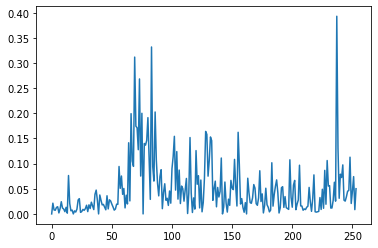

In [6]:
#plotting daily volatilities
fig, ax = plt.subplots(1, 1)
ax.plot(ticker.devObs)

In [7]:
# fitting theta parameter
t = (((ticker.devObs.std())**2))/ticker.devObs.mean()
t

0.06493861115206127

## Basic Monte Carlo Simulation

In [8]:
# fitting alpha parameter
a = ticker.devObs.mean()/t
a

0.766181779081882

In [9]:
# sanity check
print(a*t)

0.04975478062359285


In [10]:
# monte carlo sim from gamma distribution
def getVol(alpha, theta):
    u = random.uniform(0,1)
    return(st.gamma.ppf(u,a=alpha,scale = theta))

In [11]:
# sanity check 
getVol(a,t)

0.04575702574952702

In [12]:
#monte carlo sim for returns and price formula
def getPrice(s_0,mu,divs, alpha, theta):
    sigma = getVol(alpha, theta)
    u = random.uniform(0,1)
    Z = st.norm.ppf(u)
    return(s_0*math.exp(mu - divs-(.5*(sigma**2))+sigma*Z))

In [13]:
#test for 2 day paths based on last close price *non stratified*
#s1 = [getPrice(s_0 = ticker.Close[251],mu = ticker["Returns"].mean(),divs = 0,alpha = a,theta = t) for x in range(1000000)]
#s2 = [getPrice(s_0 = v,mu = ticker["Returns"].mean(),divs = 0,alpha = a,theta = t) for v in s1]

In [14]:
# day one test stats
#pd.Series(s1).describe()

In [15]:
#day two test stats
#pd.Series(s2).describe()

In [16]:
#day one histogram
#plt.hist(s1)

In [17]:
#day two histogram
#plt.hist(s2)

## Graphical Analyses and Stress Tests

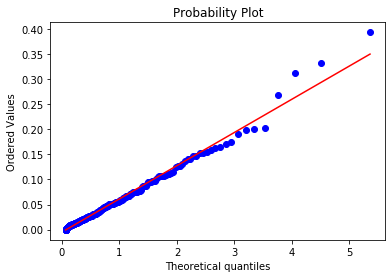

In [18]:
# probability plot of gamma against data
fig, ax = plt.subplots(1, 1)
st.probplot(ticker.devObs.sort_values(), sparams = (a,t),plot = ax,dist = 'gamma')
plt.show()

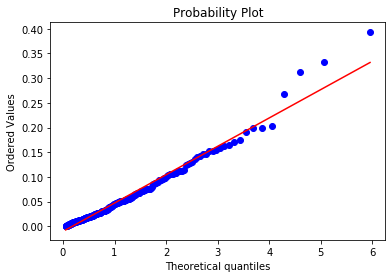

In [19]:
# probability plot of exponential against data
fig, ax = plt.subplots(1, 1)
st.probplot(ticker.devObs.sort_values(), sparams = (1,ticker.devObs.mean()),plot = ax,dist = 'gamma')
plt.show()

In [20]:
# likelihood ratio test to see if exponential is better fit for volatility
Lgam = [math.log(st.gamma.pdf(x,a=a,scale=t)) for x in ticker.devObs]
Lexp = [math.log(st.gamma.pdf(x,a = 1, scale = ticker.devObs.mean())) for x in ticker.devObs]

In [21]:
def loglikelihood(list):
    s = 0
    for i in list:
        s+=i
    return s

In [22]:
test_stat = 2*((loglikelihood(Lgam)-.5*math.log(253)-(loglikelihood(Lexp)-math.log(253))))
test_stat 
# if fail to reject on 1 degree of freedom use gamma

16.39018273047941

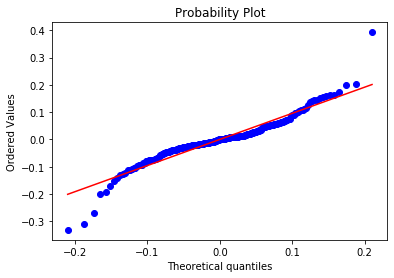

In [23]:
# probability plot of returns against data
# should have heavy tail indicator
fig, ax = plt.subplots(1, 1)
st.probplot(ticker.Returns.sort_values(), sparams = (ticker.Returns.mean(),ticker.Returns.std()),plot = ax,dist = 'norm')
plt.show()

In [24]:
#monte carlo for returns
def getReturns(mu,sigma,l,u):
    q = random.uniform(l,u)
    return st.norm.ppf(q,loc = mu, scale = sigma)

(array([ 6.,  9., 26., 45., 60., 53., 35., 12.,  7.,  1.]),
 array([-0.13774493, -0.10835469, -0.07896444, -0.04957419, -0.02018395,
         0.0092063 ,  0.03859654,  0.06798679,  0.09737704,  0.12676728,
         0.15615753]),
 <a list of 10 Patch objects>)

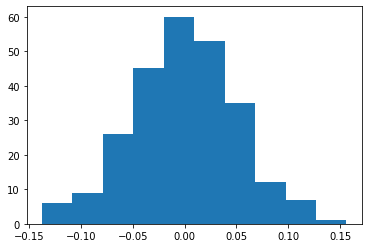

In [25]:
# test for returns
j = h = 1/len(ticker.Returns)
i = 0
test = []
while j < 1:
    x = [getReturns(mu = ticker.Returns.mean(), sigma = getVol(a,t),l = i, u = j) for x in range(100)]
    test.append(sum(x)/len(x))
    i += h
    j += h
plt.hist(test)

(array([  3.,   2.,   6.,  36., 144.,  44.,  16.,   2.,   0.,   1.]),
 array([-0.33181473, -0.25934237, -0.18687002, -0.11439766, -0.04192531,
         0.03054705,  0.1030194 ,  0.17549176,  0.24796412,  0.32043647,
         0.39290883]),
 <a list of 10 Patch objects>)

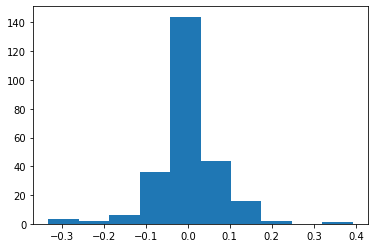

In [26]:
plt.hist(ticker.Returns)

In [27]:
st.ttest_ind(pd.Series(ticker.Returns).sort_values(),pd.Series(test).sort_values())

Ttest_indResult(statistic=0.050618419297078845, pvalue=0.9596495600965571)

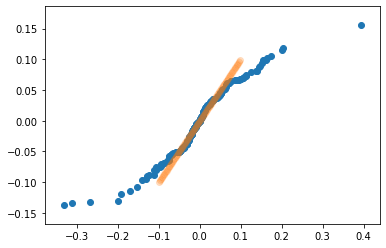

In [28]:
# qq plot for returns
# should indicate heavy tails
plt.scatter(pd.Series(ticker.Returns).sort_values(),pd.Series(test).sort_values())
plt.scatter([x/1000 for x in range(-100,100)],[x/1000 for x in range(-100,100)], alpha = .1)

(array([145.,  54.,  27.,  13.,   7.,   4.,   2.,   1.,   0.,   1.]),
 array([1.82513653e-05, 3.86163279e-02, 7.72144045e-02, 1.15812481e-01,
        1.54410558e-01, 1.93008634e-01, 2.31606711e-01, 2.70204787e-01,
        3.08802864e-01, 3.47400941e-01, 3.85999017e-01]),
 <a list of 10 Patch objects>)

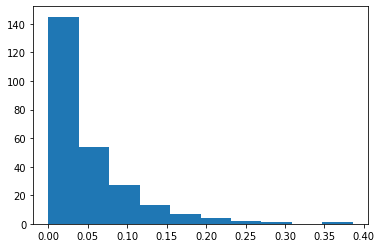

In [29]:
#Checking Stratified Volatility
def getVolStrata(alpha, theta,l,u):
    u = random.uniform(l,u)
    return(st.gamma.ppf(u,a=alpha,scale = theta))

j = h = 1/len(ticker.devObs)
i = 0
test = []
while j < 1:
    x = [getVolStrata(a,t,l = i, u = j) for x in range(100)]
    test.append(sum(x)/len(x))
    i += h
    j += h
plt.hist(test)

In [30]:
st.ttest_ind(pd.Series(ticker.devObs).sort_values(),pd.Series(test).sort_values())

Ttest_indResult(statistic=-0.002304849269019476, pvalue=0.998161906357544)

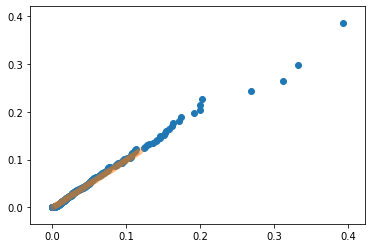

In [31]:
plt.scatter(pd.Series(ticker.devObs).sort_values(),pd.Series(test).sort_values())
plt.scatter([x/1000 for x in range(0,120)],[x/1000 for x in range(0,120)], alpha = .1)

## Stratified Monte Carlo Modeling

In [32]:
# Stratified volatility sampling
def getVolStrata(alpha, theta,l,u):
    u = random.uniform(l,u)
    return(st.gamma.ppf(u,a=alpha,scale = theta))

In [33]:
# Stratified price sampling
def getPriceStrata(s_0,mu,divs, alpha, theta,low,up,bottom,top):
    sigma = getVolStrata(alpha, theta,bottom,top)
    u = random.uniform(low,up)
    Z = st.norm.ppf(u)
    return(s_0*math.exp(mu - divs-(.5*(sigma**2))+sigma*Z))

In [83]:
# Stratified paths for next day
s1 = []
l = 0
u = .01
y = 0
z = .01
h = .01
while round(u,6) <= 1:
    while round(z,6) <= 1:
        s1.append(getPriceStrata(s_0 = ticker.Close[252],mu = ticker["Returns"].mean(),divs = 0,alpha = a,theta = t, low = l, up = u, bottom = y, top = z))
        y += h
        z += h
    l += h
    u += h
    y = 0
    z = .01

pd.Series(s1).describe()

count    10000.000000
mean        20.149356
std          1.528472
min          6.572153
25%         19.799201
50%         20.148273
75%         20.453276
max         44.846053
dtype: float64

(array([6.000e+00, 4.600e+01, 3.120e+02, 7.921e+03, 1.529e+03, 1.350e+02,
        3.700e+01, 7.000e+00, 4.000e+00, 3.000e+00]),
 array([ 8.08782371, 11.25432659, 14.42082947, 17.58733235, 20.75383523,
        23.92033812, 27.086841  , 30.25334388, 33.41984676, 36.58634964,
        39.75285252]),
 <a list of 10 Patch objects>)

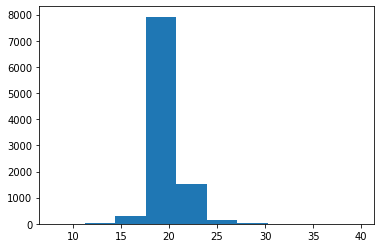

In [35]:
plt.hist(s1)

In [36]:
# Put Payoff Function
def PutPayoff(pricesT, k):
    PutPayoff = []
    for x in pricesT:
        if k-x>0:
            PutPayoff.append(k-x)
        else:
            PutPayoff.append(0)
    return pd.Series(PutPayoff)

In [37]:
# Call Payoff Function
def CallPayoff(pricesT, k):
    CallPayoff = []
    for x in pricesT:
        if x-k>0:
            CallPayoff.append(x-k)
        else:
            CallPayoff.append(0)
    return pd.Series(CallPayoff)

In [127]:
# Prices for any number of days 
# Based on initial path calculated above
def PriceIt(Stop, s_0):
    days = 0
    while days < Stop:
        s_New = []
        l = 0
        u = .01
        y = 0
        z = .01
        h = .01
        for s in s_0:
            while round(u,6) <= 1:
                while round(z,6) <= 1:
                    s_New.append(getPriceStrata(s_0 = s,mu = ticker["Returns"].mean(),divs = 0,alpha = a,theta = t, low = l, up = u, bottom = y, top = z))
                    y += h
                    z += h
                l += h
                u += h
                y = 0
                z = .01
        s_0 = s_New
        days += 1
    return pd.Series(s_New)

In [128]:
# Gives probability of jump to a loss for a put with given strike
# on day that series refers to
def getStrikePrLossPut(strike, series):
    series = pd.Series(series)
    for price in list(series.sort_values()):
        if price >= strike:
            return 1-(list(series.sort_values()).index(price)/len(list(series.sort_values())))
    return 1

In [129]:
# Gives probability of jump to a loss for a call with given strike
# on day that series refers to
def getStrikePrLossCall(strike, series):
    series = pd.Series(series)
    for price in list(series.sort_values()):
        if price >= strike:
            return (list(series.sort_values()).index(price)/len(list(series.sort_values())))
    return 1

In [130]:
# stratified pathwise monte carlo runs
# tomorrow is s1
# next day is based on s1
# mon = PriceIt(1,s1)
# tues = PriceIt(1,mon)
# wed = PriceIt(1,tues)
# th = PriceIt(1,wed)
#fr = PriceIt(1,th)

In [131]:
# one at a time, better probability estimate
s12022020 = PriceIt(1,s1)
s12032020 = PriceIt(1,s12022020)
s12042020 = PriceIt(1,s12032020)
s12072020 = PriceIt(1,s12042020)
s12082020 = PriceIt(1,s12072020)
s12092020 = PriceIt(1,s12082020)
s12102020 = PriceIt(1,s12092020)
s12112020 = PriceIt(1,s12102020)
s12142020 = PriceIt(1,s12112020)
s12152020 = PriceIt(1,s12142020)
s12162020 = PriceIt(1,s12152020)
s12172020 = PriceIt(1,s12162020)
s12182020 = PriceIt(1,s12172020)
s12212020 = PriceIt(1,s12182020)
s12222020 = PriceIt(1,s12212020)
s12232020 = PriceIt(1,s12222020)
s12242020 = PriceIt(1,s12232020)
s12252020 = PriceIt(1,s12242020)
s12282020 = PriceIt(1,s12252020)
s12292020 = PriceIt(1,s12282020)
s12302020 = PriceIt(1,s12292020)
s12312020 = PriceIt(1,s12302020)
s01012021 = PriceIt(1,s12312020)
s01042021 = PriceIt(1,s01012021)
s01052021 = PriceIt(1,s01042021)
s01062021 = PriceIt(1,s01052021)
s01072021 = PriceIt(1,s01062021)
s01082021 = PriceIt(1,s01072021)
s01112021 = PriceIt(1,s01082021)
s01122021 = PriceIt(1,s01112021)
s01132021 = PriceIt(1,s01122021)
s01142021 = PriceIt(1,s01132021)
s01152021 = PriceIt(1,s01142021)
s01182021 = PriceIt(1,s01152021)
s01192021 = PriceIt(1,s01182021)
s01202021 = PriceIt(1,s01192021)
s01212021 = PriceIt(1,s01202021)

In [159]:
#. probability estimation
k = 21
1-(getStrikePrLossPut(k,s12022020)*getStrikePrLossPut(k,s12032020)*getStrikePrLossPut(k,s12042020)*getStrikePrLossPut(k,s12072020)*getStrikePrLossPut(k,s12082020)*getStrikePrLossPut(k,s12092020)*getStrikePrLossPut(k,s12102020)*getStrikePrLossPut(k,s12112020)*getStrikePrLossPut(k,s12142020)*getStrikePrLossPut(k,s12152020)*getStrikePrLossPut(k,s12162020)*getStrikePrLossPut(k,s12172020)*getStrikePrLossPut(k,s12182020)*getStrikePrLossPut(k,s12212020)*getStrikePrLossPut(k,s12222020)*getStrikePrLossPut(k,s12232020)*getStrikePrLossPut(k,s12242020)*getStrikePrLossPut(k,s12252020)*getStrikePrLossPut(k,s12282020)*getStrikePrLossPut(k,s12292020)*getStrikePrLossPut(k,s12302020)*getStrikePrLossPut(k,s12312020)*getStrikePrLossPut(k,s01012021)*getStrikePrLossPut(k,s01042021)*getStrikePrLossPut(k,s01052021)*getStrikePrLossPut(k,s01062021)*getStrikePrLossPut(k,s01072021)*getStrikePrLossPut(k,s01082021)*getStrikePrLossPut(k,s01112021)*getStrikePrLossPut(k,s01122021)*getStrikePrLossPut(k,s01132021)*getStrikePrLossPut(k,s01142021)*getStrikePrLossPut(k,s01152021)*getStrikePrLossPut(k,s01182021)*getStrikePrLossPut(k,s01192021)*getStrikePrLossPut(k,s01202021)*getStrikePrLossPut(k,s01212021))

0.8828

In [158]:
k = 21
1-(getStrikePrLossCall(k,s12022020)*getStrikePrLossCall(k,s12032020)*getStrikePrLossCall(k,s12042020)*getStrikePrLossCall(k,s12072020)*getStrikePrLossCall(k,s12082020)*getStrikePrLossCall(k,s12092020)*getStrikePrLossCall(k,s12102020)*getStrikePrLossCall(k,s12112020)*getStrikePrLossCall(k,s12142020)*getStrikePrLossCall(k,s12152020)*getStrikePrLossCall(k,s12162020)*getStrikePrLossCall(k,s12172020)*getStrikePrLossCall(k,s12182020)*getStrikePrLossCall(k,s12212020)*getStrikePrLossCall(k,s12222020)*getStrikePrLossCall(k,s12232020)*getStrikePrLossCall(k,s12242020)*getStrikePrLossCall(k,s12252020)*getStrikePrLossCall(k,s12282020)*getStrikePrLossCall(k,s12292020)*getStrikePrLossCall(k,s12302020)*getStrikePrLossCall(k,s12312020)*getStrikePrLossCall(k,s01012021)*getStrikePrLossCall(k,s01042021)*getStrikePrLossCall(k,s01052021)*getStrikePrLossCall(k,s01062021)*getStrikePrLossCall(k,s01072021)*getStrikePrLossCall(k,s01082021)*getStrikePrLossCall(k,s01112021)*getStrikePrLossCall(k,s01122021)*getStrikePrLossCall(k,s01132021)*getStrikePrLossCall(k,s01142021)*getStrikePrLossCall(k,s01152021)*getStrikePrLossCall(k,s01182021)*getStrikePrLossCall(k,s01192021)*getStrikePrLossCall(k,s01202021)*getStrikePrLossCall(k,s01212021))

0.11719999999999997

In [134]:
dailyprices = [s12022020,s12032020,s12042020,s12072020,s12082020,s12092020,s12102020,s12112020,s12142020,s12152020,s12162020,s12172020,s12182020,s12212020,s12222020,s12232020,s12242020,s12252020,s12282020,s12292020,s12302020,s12312020,s01012021,s01042021,s01052021,s01062021,s01072021,s01082021,s01112021,s01122021,s01132021,s01142021,s01152021,s01182021,s01192021,s01202021,s01212021]

In [135]:
means = []
for day in dailyprices:
    means.append(day.mean())
means

[20.14828072423046,
 20.14324928377121,
 20.135586681680934,
 20.13443367566937,
 20.135510294728917,
 20.133869465823345,
 20.127055582213718,
 20.13015183069753,
 20.120371617159666,
 20.121990948543345,
 20.113506565692216,
 20.11095548137281,
 20.105284531883964,
 20.101863373852925,
 20.098394818539006,
 20.101630394264042,
 20.099382127834883,
 20.09149459624872,
 20.091389841117653,
 20.083574906579983,
 20.088254803570507,
 20.083954509159096,
 20.076704289342956,
 20.07064833446652,
 20.063349644176338,
 20.061976979947204,
 20.056242937402533,
 20.051870444420732,
 20.049411413490063,
 20.048748503969694,
 20.047999726380723,
 20.045259194119115,
 20.03757329533914,
 20.02928411681458,
 20.02670527320975,
 20.022059386741752,
 20.02207285631946]

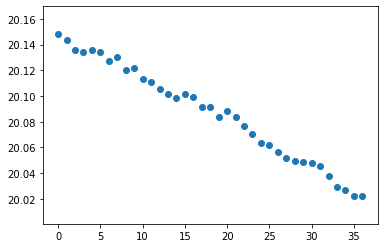

In [136]:
plt.scatter([i for i in range(len(means))],means)

In [137]:
def PutPrune(sa,sb,k):
    sc = sa
    ave = sum(PutPayoff(sb,k))/len(PutPayoff(sb,k))
    i = 0
    while i < len(sa):
        if k-sc[i] <= ave:
            sc[i] = ave
        else:
            sc[i] = k - sc[i]
        i+= 1
    return sc

In [138]:
def CallPrune(sa,sb,k):
    sc = sa
    ave = sum(CallPayoff(sb,k))/len(CallPayoff(sb,k))
    i = 0
    while i < len(sa):
        if sc[i]-k <= ave:
            sc[i] = ave
        else:
            sc[i] = sc[i]-k
        i+= 1
    return sc

In [139]:
def RecursivePutPrune(prices,k):
    a = 2
    b = 1
    while a < len(prices):
        pruned = PutPrune(prices[-a],prices[-b],k)
        pruned = PutPrune(prices[-a-1],pruned,k)
        a+= 1
        b += 1
    return pd.Series(pruned)

In [140]:
def RecursiveCallPrune(prices,k):
    a = 2
    b = 1
    while a < len(prices):
        pruned = CallPrune(prices[-a],prices[-b],k)
        pruned = CallPrune(prices[-a-1],pruned,k)
        a+= 1
        b += 1
    return pd.Series(pruned)

In [141]:
pruned = RecursivePutPrune(dailyprices,21)
pruned.describe()

count    10000.000000
mean         4.180467
std          0.329179
min          4.145134
25%          4.145134
50%          4.145134
75%          4.145134
max         14.197842
dtype: float64

In [142]:
pruned = RecursiveCallPrune(dailyprices,21)
pruned.describe()

count    10000.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
dtype: float64

Text(0, 0.5, 'Observations')

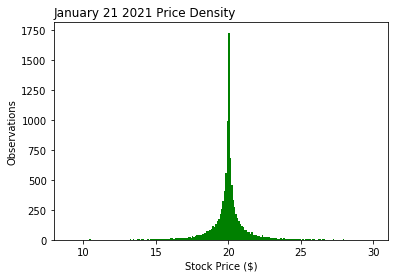

In [143]:
binwidth = .1
plt.title("January 21 2021 Price Density",loc = 'left')
plt.hist(s01212021, bins=np.arange(9, 30 + binwidth, binwidth),color = "green")
plt.xlabel('Stock Price ($)')
plt.ylabel('Observations')

In [53]:
os.system('say -v "Daniel" "The program is complete sir, will there be anything else?"')
print('\a\a\a')




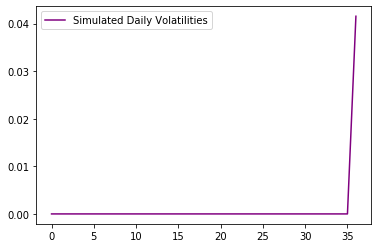

In [144]:
returns = [x.pct_change().fillna(0) for x in dailyprices]
fig, ax = plt.subplots(1, 1)
ax.plot([x.std() for x in returns],label = "Simulated Daily Volatilities",color = 'purple')
ax.legend()

In [145]:
s01212021.describe()

count    10000.000000
mean        20.022073
std          1.544878
min          8.379908
25%         19.674595
50%         20.020677
75%         20.322300
max         61.366914
dtype: float64

In [163]:
pd.Series(means).describe()

count    37.000000
mean     20.086759
std       0.038004
min      20.022059
25%      20.051870
50%      20.091390
75%      20.120372
max      20.148281
dtype: float64